#### First things first

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('train.csv').drop(columns = 'id')
df.head()

,text,is_humor,humor_rating,humor_controversy,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


#### selecting rows where the text is classified as humorous

In [3]:
X = df[df['is_humor']==1][['text']] #4932 Do not reset the index!
y = df[df['is_humor']==1][['humor_rating']] #4932

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
"X_train and y_train shape: {0}, {1}, X_test and y_test shape {2}, {3}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'X_train and y_train shape: (3945, 1), (3945, 1), X_test and y_test shape (987, 1), (987, 1)'

In [5]:
y_train.describe()

,humor_rating
count,3945.000000
mean,2.262378
std,0.569339
min,0.100000
25%,1.890000
50%,2.280000
75%,2.670000
max,4.000000


<a list of 1 Patch objects>

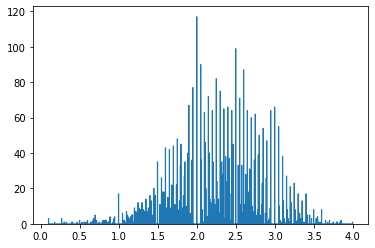

In [6]:
_, _, histogram = plt.hist(y_train['humor_rating'], bins = 1000, histtype = 'step')
histogram

#### helper functions

In [7]:
def stemmer(text, stemmer):
    return(' '.join([stemmer.stem(w) for w in word_tokenize(text)]))

def count_words(input):
    """ Returns number of occurences of characters specified in char """     
    return len(input.split())

def remove_punctuation(s_input, include_char = None):
    """ Returns input string without punctuation """
    import string as String
    punct = String.punctuation
    
    if not include_char is None:
        index = String.punctuation.index(include_char)
        punct = String.punctuation[:index] + String.punctuation[(index + 1):]
        
    punct += '\n'
        
    translator = str.maketrans(punct, ' '*len(punct))
    
    return s_input.translate(translator)

def remove_stopwords(text, use_stopwords = None, df = True, exclude_number = True):
    """ Returns input string removing stopwords from it. """
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    if use_stopwords is None:
        use_stopwords = set(stopwords.words("english"))
        
    if df:
        new_text = word_tokenize(text)
        if exclude_number:
            new_text = [word for word in new_text if not word.isnumeric()]
        new_text = " ".join([word for word in new_text if word not in use_stopwords])
    else:
        new_text = ""
        for word in text:
            if word not in use_stopwords:
                new_text += word + " "

    return new_text

def sep_upper(text):
    """ Take a text as input and insert space before every uppercase letter. """
    
    new_text = ""
    for letter in text:
        if letter.isupper():
            new_text += " " + letter
        else:
            new_text += letter
    
    return new_text

def remove_space(text):
    return(re.sub(' +',' ',text)) 

#### (basic) pre-process of text columns

In [8]:
def pre_proc(text_col):
    text_col = text_col.apply(remove_punctuation) # removes String.punctuation characters
    #text_col = text_col.apply(remove_stopwords)   # removes english stopwords 
    text_col = text_col.str.replace('[^\w\s]','').str.strip() # and removes whitespaces
    text_col = text_col.apply(sep_upper) # adds space before an uppercase
    text_col = text_col.str.lower() # lowercase
    
    return text_col

In [9]:
X_train.text = pre_proc(X_train.text)
X_test.text = pre_proc(X_test.text)

C:\Users\vipac\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### basic new features

In [10]:
X_train['qtd_words'] = X_train.text.apply(count_words)
X_test['qtd_words'] = X_test.text.apply(count_words)

C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### wait for it

In [16]:
vectorizer = CountVectorizer()


X_train_trans = pd.DataFrame(vectorizer.fit_transform(X_train.text).toarray()
                             , columns = vectorizer.get_feature_names()
                             , index = X_train.index)
X_train_trans['qtd_words'] = X_train['qtd_words']

X_test_trans = pd.DataFrame(vectorizer.transform(X_test.text).toarray()
                            , columns = vectorizer.get_feature_names()
                            , index = X_test.index)
X_test_trans['qtd_words'] = X_test['qtd_words']
#X_test.text = vectorizer.transform(X_test.text).toarray()
# print(vectorizer.get_feature_names())

In [26]:
X_train.head()

,text,qtd_words
3100,what s hitler s favorite chinese food lo ...,10
4361,the main reason i don t need to drink a lot ...,32
234,what sex position produces the ugliest childr...,10
1451,twitter always says i should follow celebrit...,24
1846,stove top stuffing is my favorite side dish...,15


In [24]:
reg = ElasticNet()
reg.fit(X_train_trans, y_train)

y_pred = reg.predict(X_test_trans)
mean_squared_error(y_test, y_pred, squared = False) # squared = F will return the RMSE

0.31073917832380443